In [1]:
# Double Q-learning, SARSA(λ), Q(λ), Dyna-Q

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{:.2f}'.format(v).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=2, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [9]:
def mean_return(env, pi, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [10]:
def regret_accumulation(env, pi, optimal_Q, iterations=10):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            state, reward, done, _ = env.step(action)
            results[-1] += regret
    return np.mean(results)

In [11]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [12]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

In [14]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

In [15]:
env = gym.make('NoisyWalkSeven-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, 0.99)
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=8)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |

Optimal action-value function:
╒═════╤═════════╤═════════╕
│   s │       < │       > │
╞═════╪═════════╪═════════╡
│   0 │ 0       │ 0       │
├─────┼─────────┼─────────┤
│   1 │ 0.31194 │ 0.56374 │
├─────┼─────────┼─────────┤
│   2 │ 0.67026 │ 0.76304 │
├─────┼─────────┼─────────┤
│   3 │ 0.80324 │ 0.84489 │
├─────┼─────────┼─────────┤
│   4 │ 0.8638  │ 0.88924 │
├─────┼─────────┼─────────┤
│   5 │ 0.90143 │ 0.92199 │
├─────┼─────────┼─────────┤
│   6 │ 0.93219 │ 0.95153 │
├─────┼─────────┼─────────┤
│   7 │ 0.96127 │ 0.9806  │
├─────┼─────────┼─────────┤
│   8 │ 0       │ 0       │
╘═════╧═════════╧═════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 97.90%. Obtains an average undiscounted return of 0.9790.


# Double Q-Learning

In [16]:
def double_q_learning(env,
                      gamma=1.0,
                      init_alpha=0.5,
                      min_alpha=0.01,
                      alpha_decay_ratio=0.3,
                      init_epsilon=1.0,
                      min_epsilon=0.1,
                      epsilon_decay_ratio=0.9,
                      n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q1 = np.zeros((nS, nA))
    Q2 = np.zeros((nS, nA))
    Q_track1 = np.zeros((n_episodes, nS, nA))
    Q_track2 = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q1 + Q2, epsilon)
            next_state, reward, done, _ = env.step(action)

            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_estimate = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_estimate - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alpha * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_estimate = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_estimate - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alpha * td_error
            state = next_state

        Q_track1[t] = Q1
        Q_track2[t] = Q2        
        pi_track.append(np.argmax(Q1 + Q2, axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, (Q_track1 + Q_track2)/2., pi_track

In [17]:
Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=0.99)

In [18]:
print_state_value_function(V_dql, P, n_cols=9, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dql, goal_state=8)*100))

State-value function found by Double Q-Learning:
|           | 01   0.56 | 02   0.74 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01  -0.01 | 02  -0.02 | 03  -0.01 | 04   0.00 | 05   0.00 | 06   0.00 | 07  -0.00 |           |
State-value function RMSE: 0.0084

Double Q-Learning action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       > │     * < │     * > │     er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.33513 │ 0.55613 │ 0.31194 │ 0.56374 │ -0.0232  │  0.00761 │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼────────

# SARSA(λ)

In [19]:
def sarsa_lambda(env,
                 gamma=1.0,
                 init_alpha=0.5,
                 min_alpha=0.01,
                 alpha_decay_ratio=0.3,
                 init_epsilon=1.0,
                 min_epsilon=0.1,
                 epsilon_decay_ratio=0.9,
                 lambda_=0.3,
                 n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    E = np.zeros((nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        E.fill(0)
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 

        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)

            td_estimate = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_estimate - Q[state][action]
            E[state][action] = E[state][action] + 1
            Q = Q + alpha * td_error * E
            E = gamma * lambda_ * E
            
            state, action = next_state, next_action

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [20]:
Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env)

In [21]:
print_state_value_function(V_sl, P, n_cols=9, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sl, goal_state=8)*100))

State-value function found by SARSA(λ):
|           | 01   0.54 | 02   0.79 | 03   0.92 | 04   0.97 | 05   0.99 | 06   1.00 | 07   1.00 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01  -0.02 | 02   0.03 | 03   0.08 | 04   0.08 | 05   0.07 | 06   0.05 | 07   0.02 |           |
State-value function RMSE: 0.0488

SARSA(λ) action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       > │     * < │     * > │     er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.24281 │ 0.54315 │ 0.31194 │ 0.56374 │  0.06912 │  0.02058 │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   2 │ 0.6247

# Watkins' Q(λ)

In [22]:
def q_lambda(env,
             gamma=1.0,
             init_alpha=0.5,
             min_alpha=0.01,
             alpha_decay_ratio=0.3,
             init_epsilon=1.0,
             min_epsilon=0.1,
             epsilon_decay_ratio=0.9,
             lambda_=0.3,
             n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    E = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        E.fill(0)
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            
            next_greedy_action = np.argmax(Q[next_state])
            if Q[next_state][next_action] == Q[next_state][next_greedy_action]:
                next_greedy_action = next_action

            td_estimate = reward + gamma * Q[next_state][next_greedy_action] * (not done)
            td_error = td_estimate - Q[state][action]
            E[state][action] = np.clip(E[state][action] + 1, 0, 1)
            Q = Q + alpha * td_error * E
            if next_action == next_greedy_action:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [23]:
Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99)

In [24]:
print_state_value_function(V_qll, P, n_cols=9, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_qll, goal_state=8)*100))

State-value function found by Q(λ):
|           | 01   0.54 | 02   0.75 | 03   0.85 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01  -0.03 | 02  -0.01 | 03   0.00 | 04  -0.00 | 05  -0.00 | 06   0.00 | 07   0.00 |           |
State-value function RMSE: 0.0097

Q(λ) action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       > │     * < │     * > │     er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.2563  │ 0.53671 │ 0.31194 │ 0.56374 │  0.05563 │  0.02703 │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   2 │ 0.65938 │ 0.75

# Dyna-Q

In [25]:
def dyna_q(env,
           gamma=1.0,
           init_alpha=0.5,
           min_alpha=0.01,
           alpha_decay_ratio=0.3,
           init_epsilon=1.0,
           min_epsilon=0.1,
           epsilon_decay_ratio=0.9,
           n_planning=10,
           n_episodes=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    T_count = np.zeros((nS, nA, nS))
    R_model = np.zeros((nS, nA, nS))

    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 

        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_estimate = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_estimate - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error

            backup_next_state = next_state
            for _ in range(n_planning):
                if Q.sum() == 0: break

                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                reward = R_model[state][action][next_state]
                    
                td_estimate = reward + gamma * Q[next_state].max()
                td_error = td_estimate - Q[state][action]
                Q[state][action] = Q[state][action] + alpha * td_error

            state = backup_next_state

        Q_track[t] = Q        
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [26]:
Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99)

In [27]:
print_state_value_function(V_dq, P, n_cols=9, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dq, goal_state=8)*100))

State-value function found by Dyna-Q:
|           | 01   0.57 | 02   0.75 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01   0.01 | 02  -0.02 | 03  -0.01 | 04  -0.00 | 05  -0.00 | 06   0.00 | 07  -0.00 |           |
State-value function RMSE: 0.0066

Dyna-Q action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       > │     * < │     * > │     er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.34336 │ 0.56941 │ 0.31194 │ 0.56374 │ -0.03142 │ -0.00567 │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   2 │ 0.67744 │ 

# Comparison of max(Q) for every episode

## Double Q-Learning

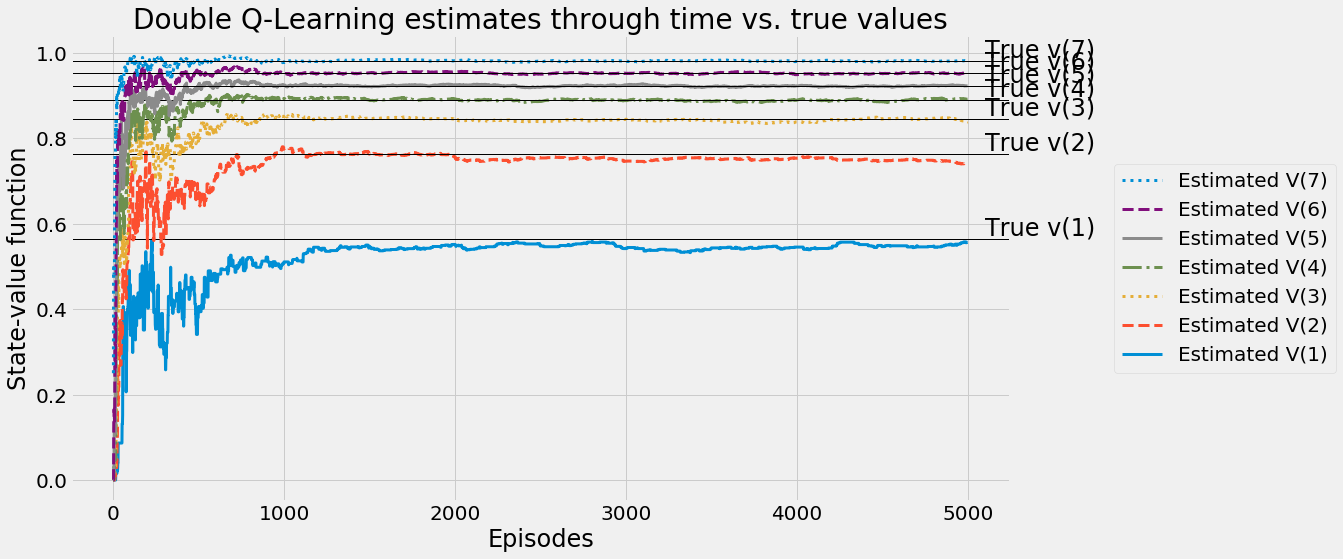

In [28]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    log=False)

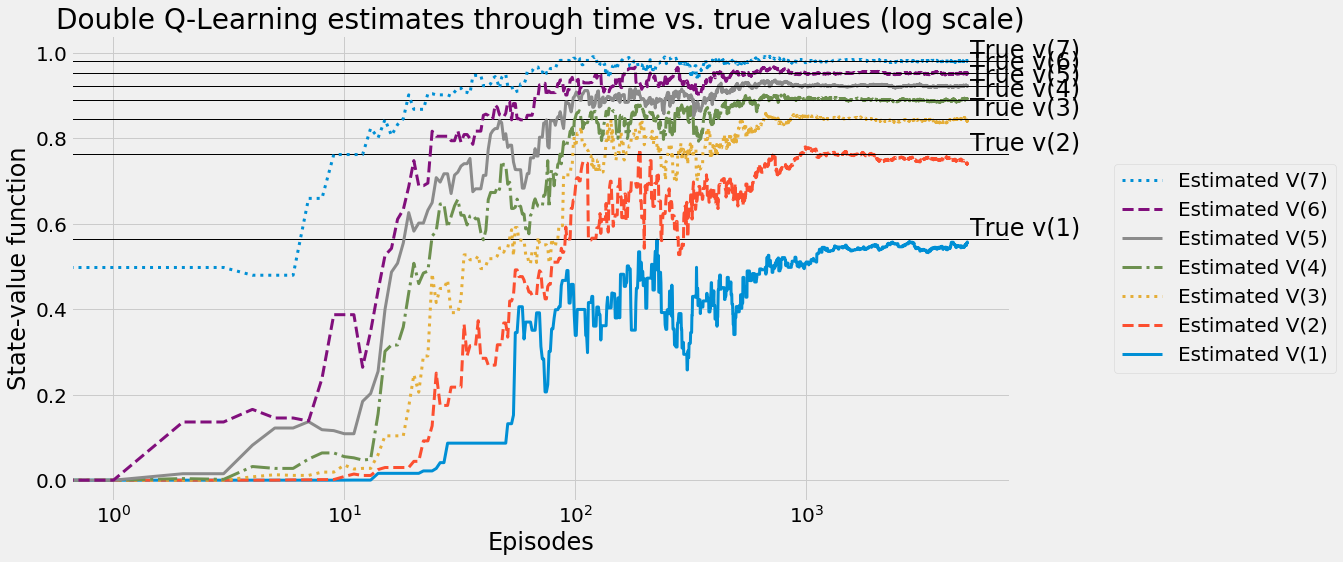

In [29]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    log=True)

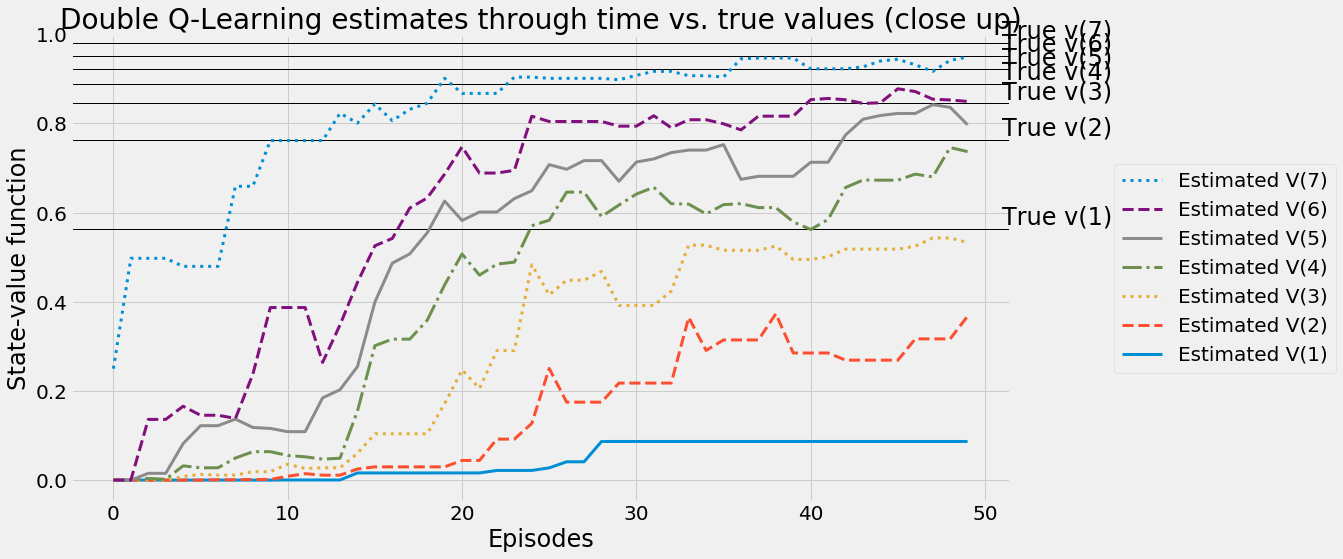

In [30]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (close up)', 
    np.max(Q_track_dql, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## SARSA(λ)

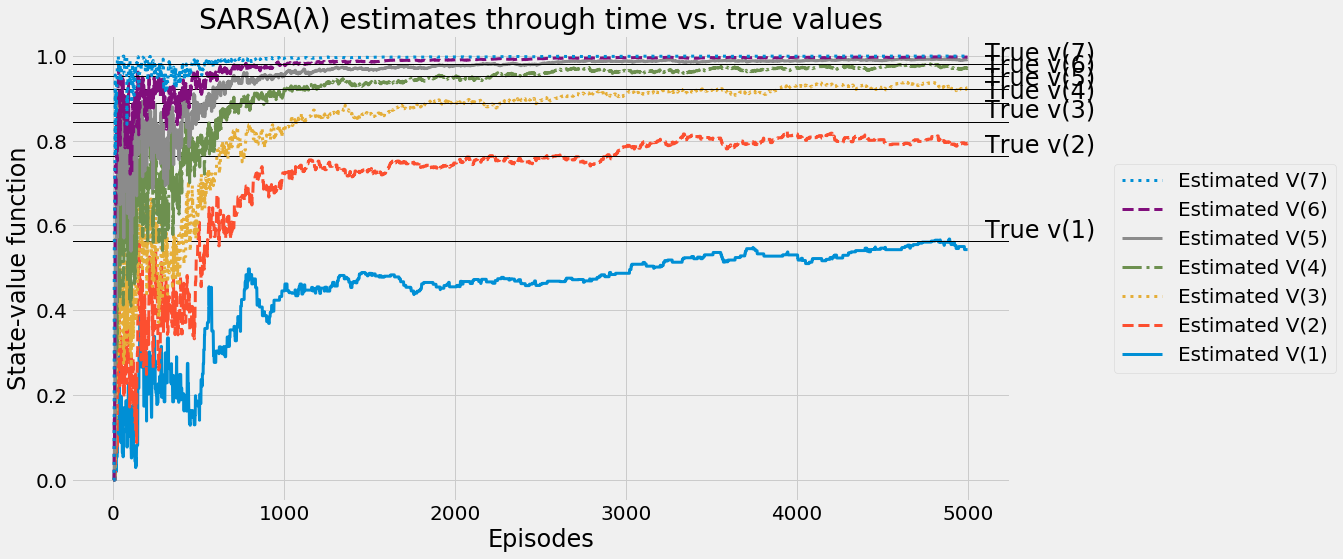

In [31]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    log=False)

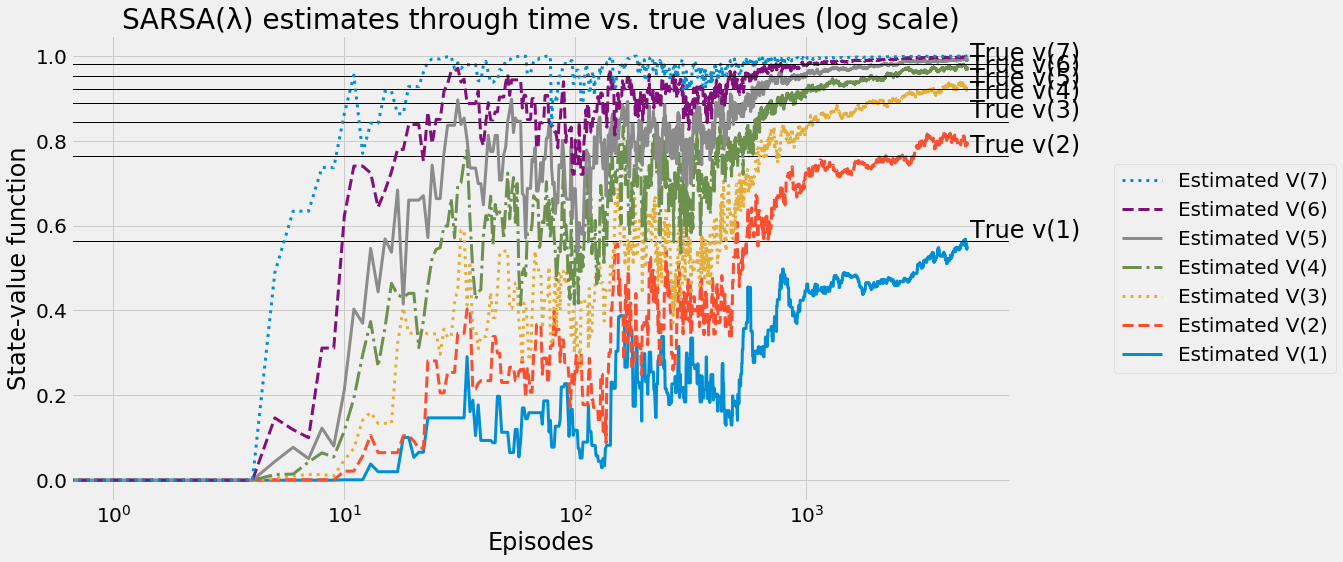

In [32]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    log=True)

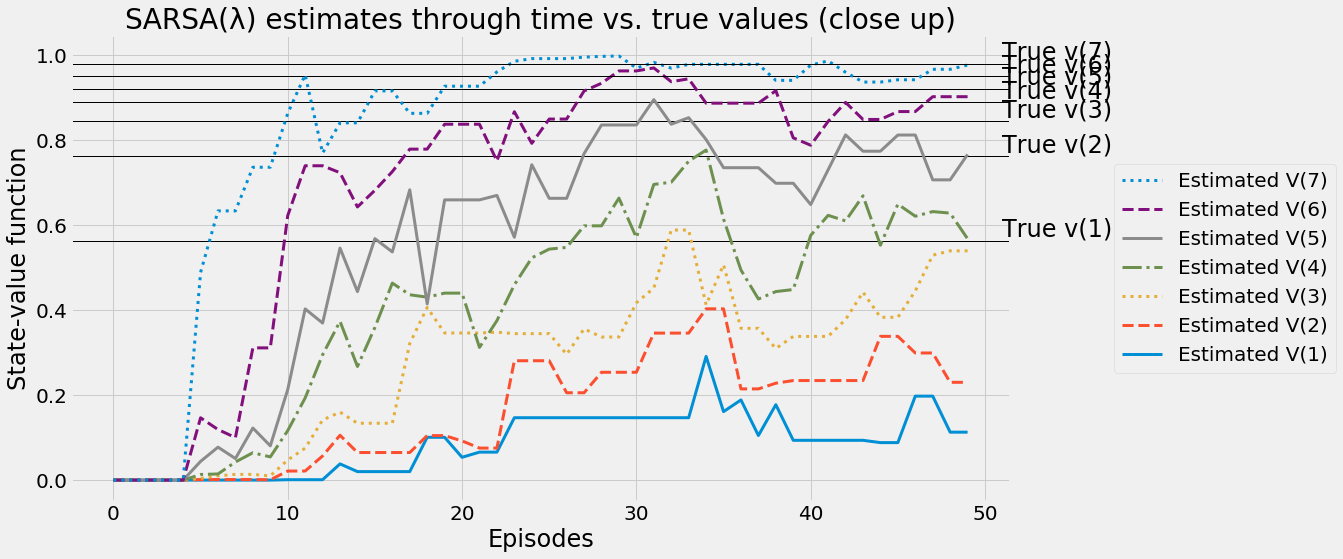

In [33]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (close up)', 
    np.max(Q_track_sl, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## Q(λ)

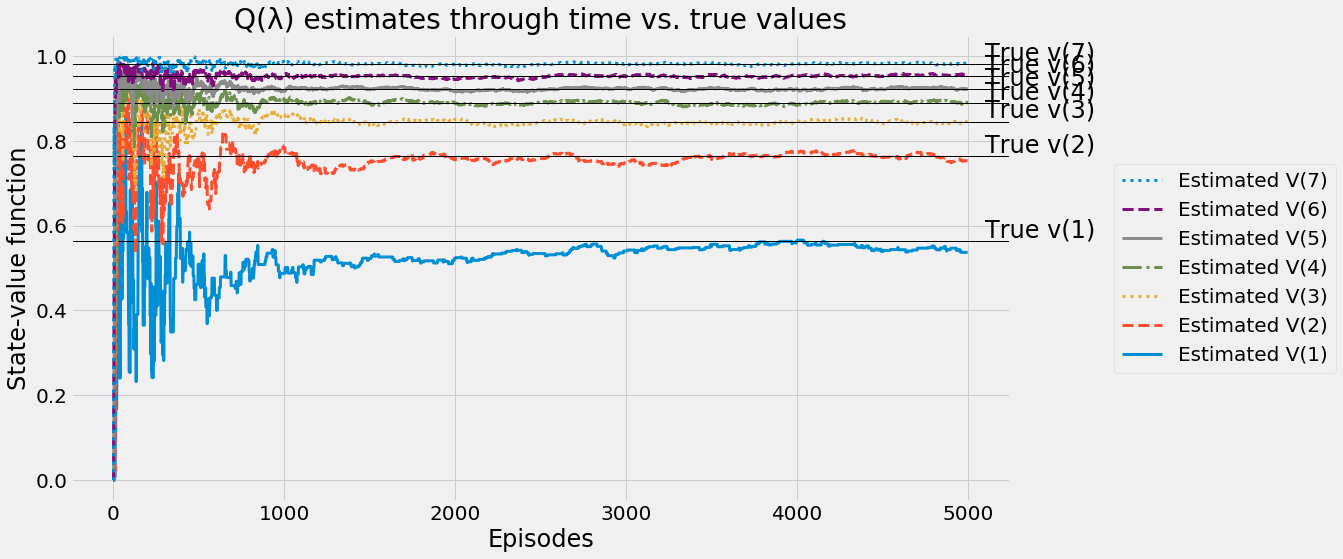

In [34]:
plot_value_function(
    'Q(λ) estimates through time vs. true values', 
    np.max(Q_track_qll, axis=2), 
    optimal_V,
    log=False)

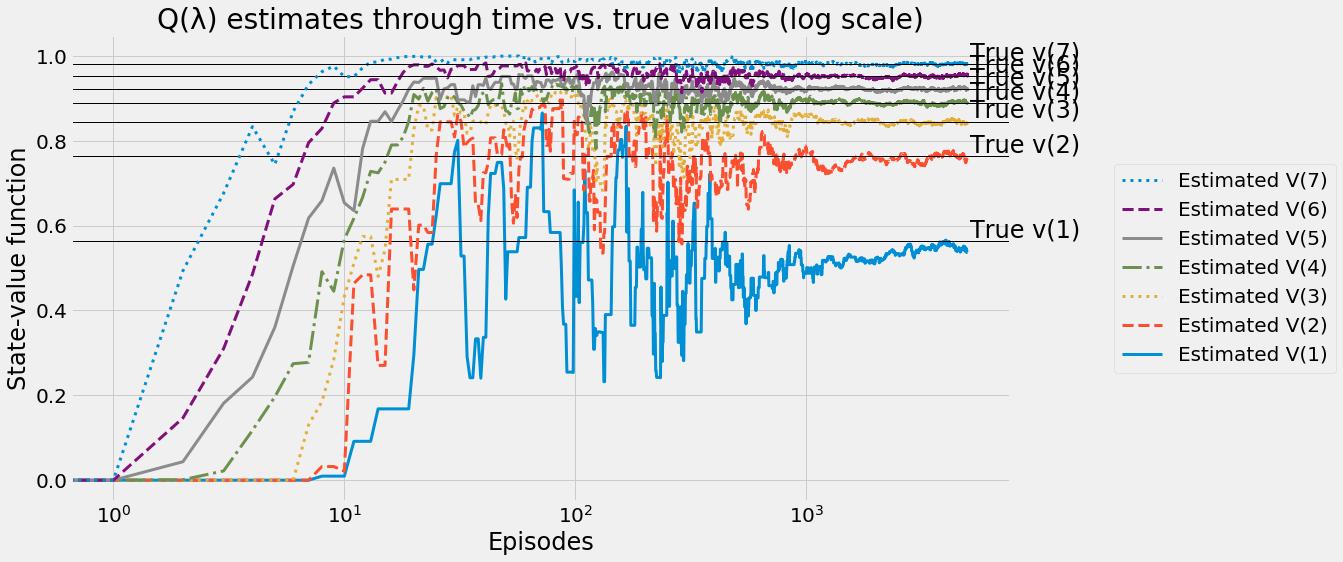

In [35]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_qll, axis=2), 
    optimal_V, 
    log=True)

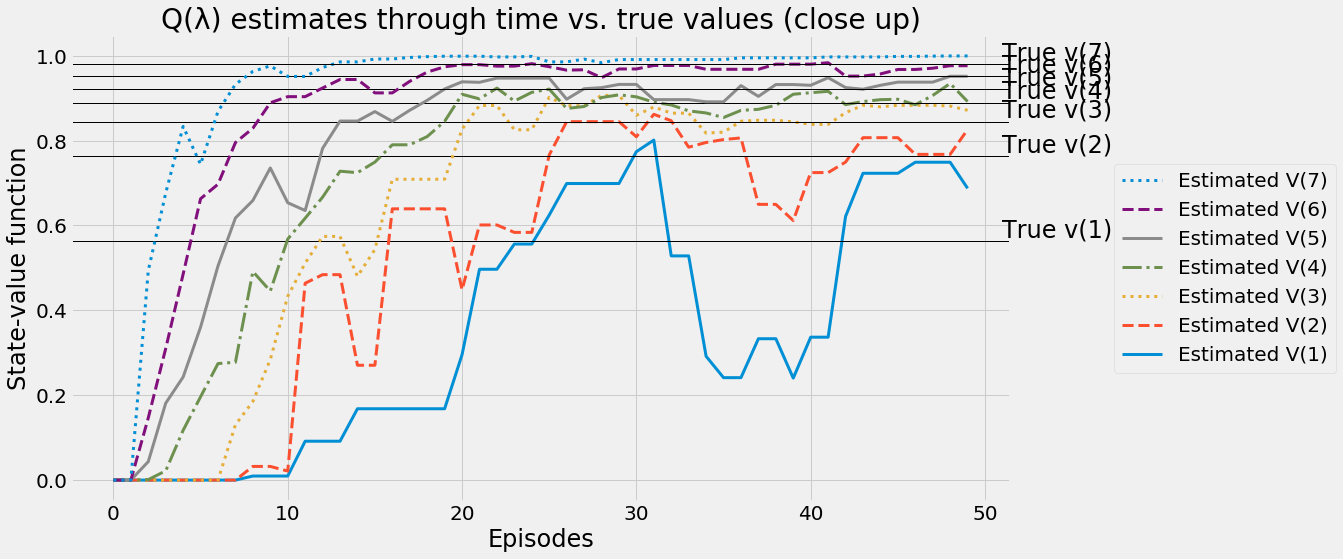

In [36]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (close up)', 
    np.max(Q_track_qll, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# Dyna-Q

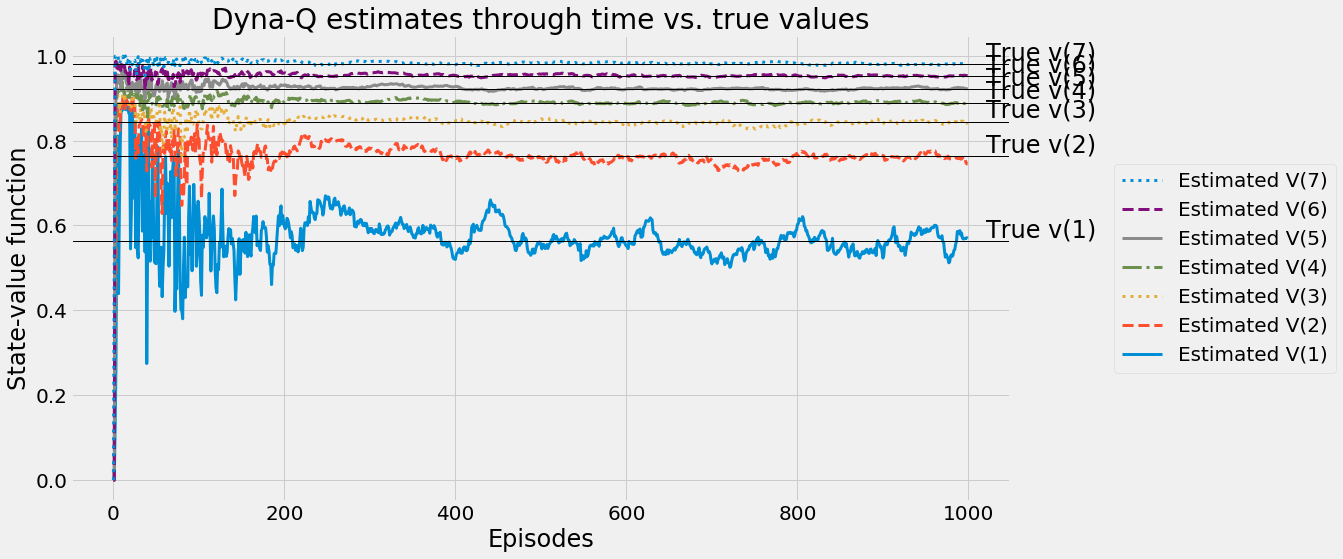

In [37]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    log=False)

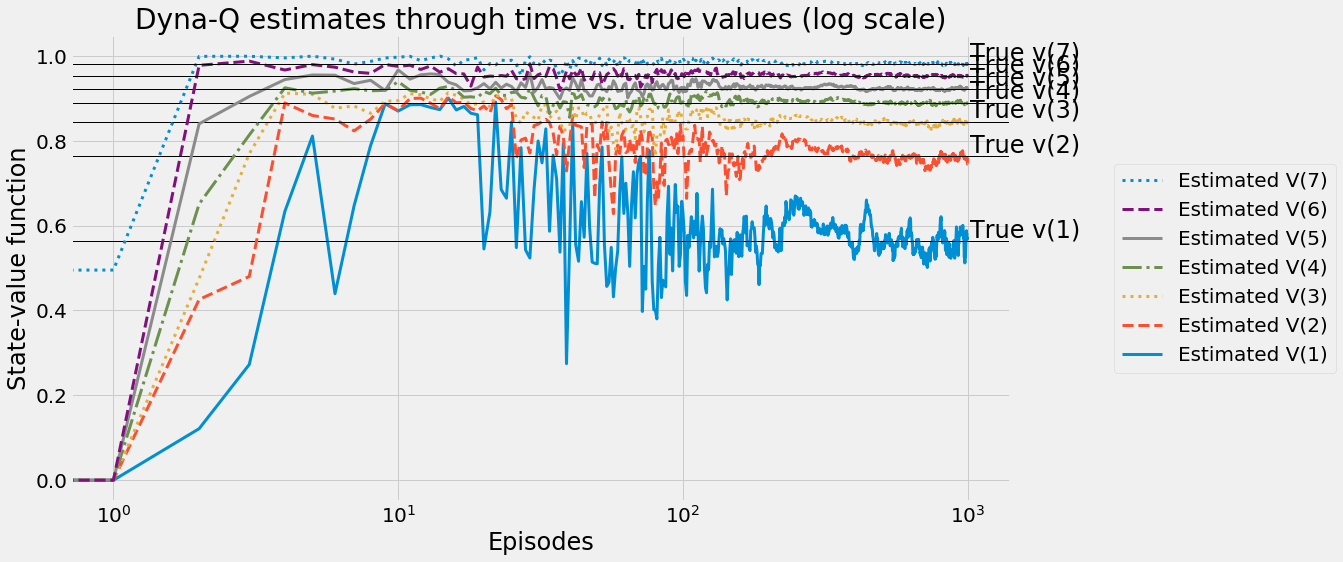

In [38]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (log scale)', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    log=True)

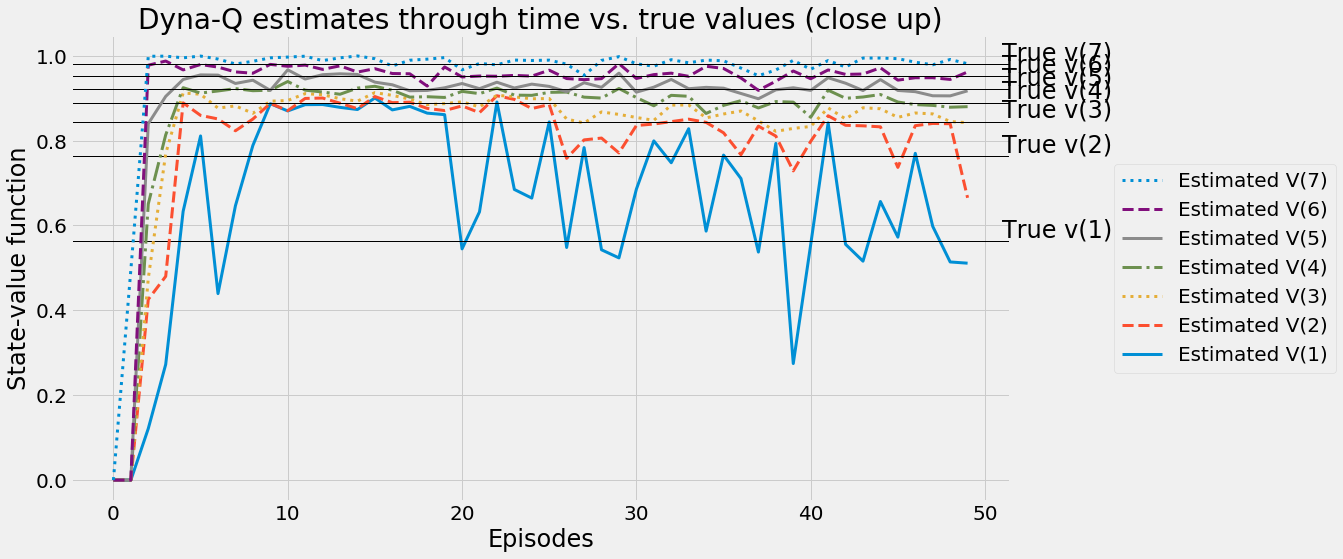

In [39]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (close up)', 
    np.max(Q_track_dq, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# FrozenLake environment

In [40]:
env = gym.make('FrozenLake-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=5, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=15)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |

Optimal action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╕
│   s │       < │       v │       > │       ^ │
╞═════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.54203 │ 0.52776 │ 0.52776 │ 0.52234 │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   1 │ 0.34347 │ 0.3342  │ 0.31993 │ 0.4988  │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   2 │ 0.43819 │ 0.43362 │ 0.42435 │ 0.4707  │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   3 │ 0.30609 │ 0.30609 │ 0.30152 │ 0.45685 │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   4 │ 0.55845 │ 0.37958 │ 0.37416 │ 0.36316 │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   5 │ 0       │ 0       │ 0       │ 0       │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   6 │ 0.35835 │ 

In [41]:
Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=0.99, n_episodes=20000)

In [42]:
print_state_value_function(V_dql, P, n_cols=4, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dql, goal_state=15)*100))

State-value function found by Double Q-Learning:
| 00   0.51 | 01   0.42 | 02   0.36 | 03   0.29 |
| 04   0.52 |           | 06   0.30 |           |
| 08   0.56 | 09   0.61 | 10   0.58 |           |
|           | 13   0.72 | 14   0.86 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.03 | 01  -0.08 | 02  -0.11 | 03  -0.16 |
| 04  -0.03 |           | 06  -0.06 |           |
| 08  -0.03 | 09  -0.03 | 10  -0.04 |           |
|           | 13  -0.02 | 14   0.00 |           |
State-value function RMSE: 0.0588

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │


In [43]:
Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99, n_episodes=20000)

In [44]:
print_state_value_function(V_sl, P, n_cols=4, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sl, goal_state=15)*100))

State-value function found by SARSA(λ):
| 00   0.30 | 01   0.25 | 02   0.21 | 03   0.16 |
| 04   0.32 |           | 06   0.21 |           |
| 08   0.36 | 09   0.45 | 10   0.44 |           |
|           | 13   0.58 | 14   0.78 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.24 | 01  -0.25 | 02  -0.26 | 03  -0.29 |
| 04  -0.24 |           | 06  -0.15 |           |
| 08  -0.23 | 09  -0.20 | 10  -0.18 |           |
|           | 13  -0.16 | 14  -0.09 |           |
State-value function RMSE: 0.1778

SARSA(λ) action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪═══

In [45]:
Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99, n_episodes=20000)

In [46]:
print_state_value_function(V_qll, P, n_cols=4, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_qll, goal_state=15)*100))

State-value function found by Q(λ):
| 00   0.53 | 01   0.47 | 02   0.44 | 03   0.42 |
| 04   0.54 |           | 06   0.34 |           |
| 08   0.59 | 09   0.64 | 10   0.61 |           |
|           | 13   0.74 | 14   0.86 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.02 | 01  -0.03 | 02  -0.03 | 03  -0.04 |
| 04  -0.02 |           | 06  -0.02 |           |
| 08  -0.01 | 09   0.00 | 10  -0.01 |           |
|           | 13  -0.00 | 14   0.00 |           |
State-value function RMSE: 0.0161

Q(λ) action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪═══════╪═══

In [47]:
Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99, n_episodes=10000)

In [48]:
print_state_value_function(V_dq, P, n_cols=4, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dq, goal_state=15)*100))

State-value function found by Dyna-Q:
| 00   0.53 | 01   0.49 | 02   0.46 | 03   0.45 |
| 04   0.54 |           | 06   0.36 |           |
| 08   0.58 | 09   0.64 | 10   0.59 |           |
|           | 13   0.73 | 14   0.87 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.02 | 01  -0.01 | 02  -0.01 | 03  -0.01 |
| 04  -0.02 |           | 06   0.01 |           |
| 08  -0.01 | 09  -0.01 | 10  -0.03 |           |
|           | 13  -0.01 | 14   0.00 |           |
State-value function RMSE: 0.0107

Dyna-Q action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪═══════

# Policy evolution comparison

In [49]:
dql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_dql)])

In [50]:
sl_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_sl)])

In [51]:
qll_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_qll)])

In [52]:
dq_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_dq)])

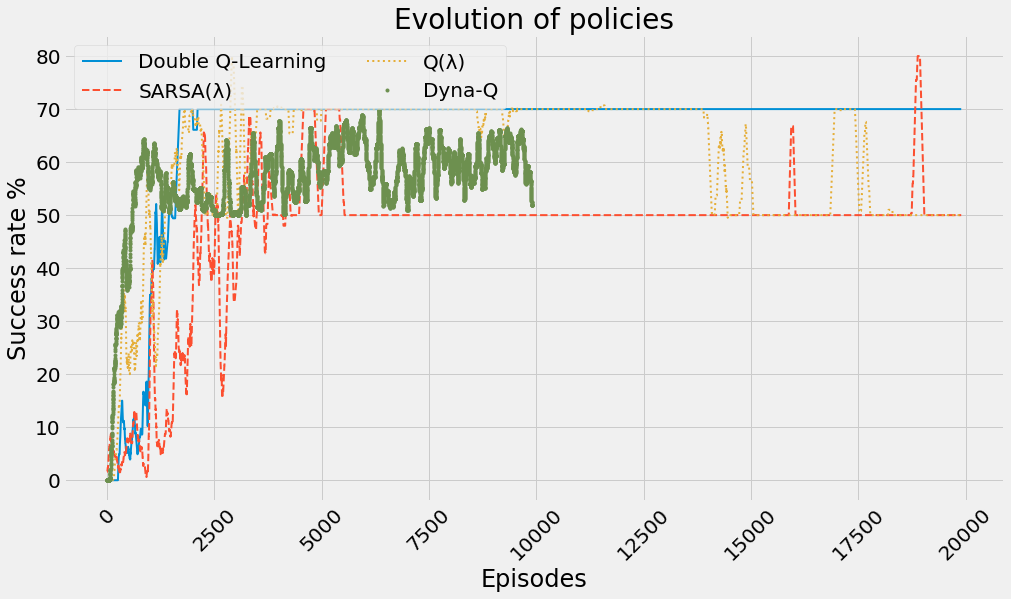

In [53]:
plt.plot(dql_success_evolution, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_success_evolution, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_evolution, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_success_evolution, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

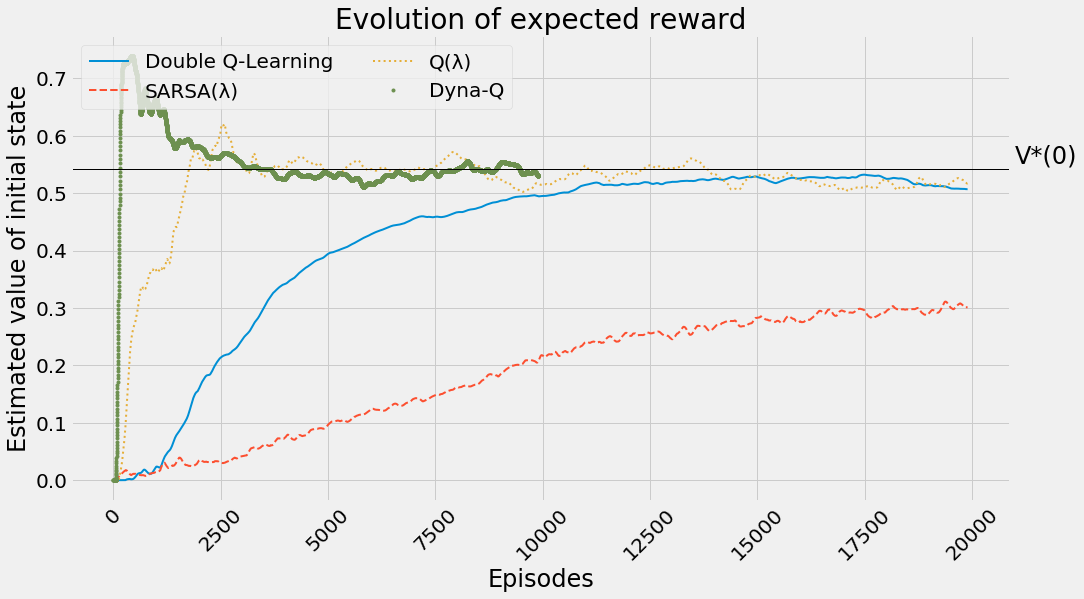

In [54]:
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[0]), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[0]), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[0]), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_dql)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

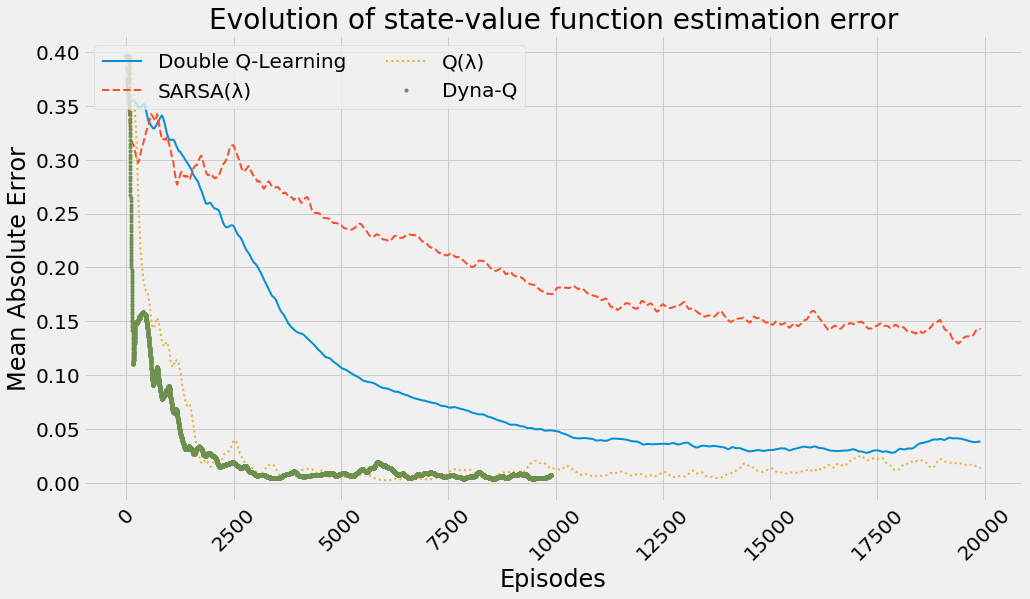

In [55]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

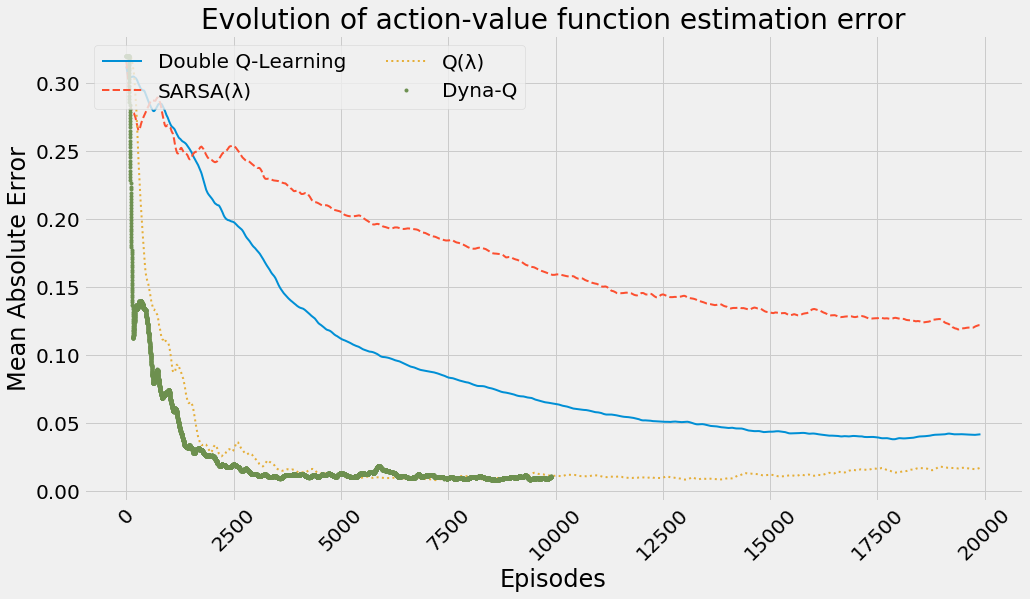

In [56]:
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [57]:
dql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dql)])

In [58]:
sl_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sl)])

In [59]:
qll_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_qll)])

In [60]:
dq_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dq)])

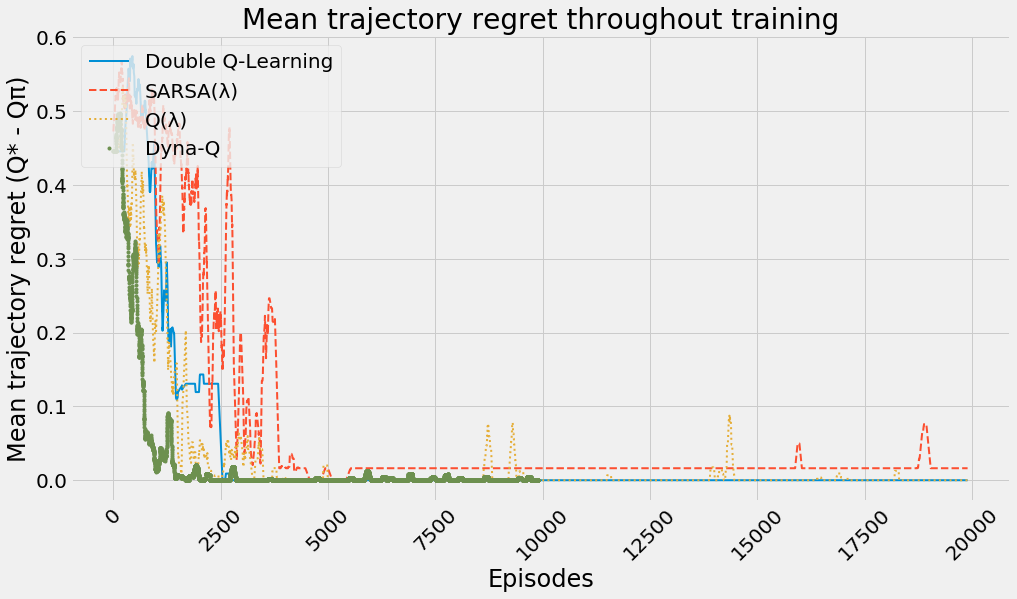

In [61]:
plt.plot(dql_regret_accumulation, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_regret_accumulation, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_regret_accumulation, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_regret_accumulation, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

# FrozenLake XL (8x8)

In [62]:
env = gym.make('FrozenLake8x8-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=8, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=5, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=63)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 | 12   0.48 | 13   0.51 | 14   0.55 | 15   0.56 |
| 16   0.40 | 17   0.39 | 18   0.38 |           | 20   0.42 | 21   0.49 | 22   0.56 | 23   0.59 |
| 24   0.37 | 25   0.35 | 26   0.31 | 27   0.20 | 28   0.30 |           | 30   0.57 | 31   0.63 |
| 32   0.33 | 33   0.29 | 34   0.20 |           | 36   0.29 | 37   0.36 | 38   0.53 | 39   0.69 |
| 40   0.31 |           |           | 43   0.09 | 44   0.21 | 45   0.27 |           | 47   0.77 |
| 48   0.29 |           | 50   0.06 | 51   0.05 |           | 53   0.25 |           | 55   0.88 |
| 56   0.28 | 57   0.20 | 58   0.13 |           | 60   0.24 | 61   0.49 | 62   0.74 |           |

Optimal action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╕
│   s │       < │       v │       > │       ^ │
╞═════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.

In [63]:
Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=0.99, n_episodes=40000)

In [64]:
print_state_value_function(V_dql, P, n_cols=8, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=8, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=8, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dql, goal_state=63)*100))

State-value function found by Double Q-Learning:
| 00   0.38 | 01   0.39 | 02   0.41 | 03   0.43 | 04   0.45 | 05   0.47 | 06   0.49 | 07   0.50 |
| 08   0.38 | 09   0.39 | 10   0.40 | 11   0.42 | 12   0.44 | 13   0.47 | 14   0.50 | 15   0.52 |
| 16   0.36 | 17   0.35 | 18   0.33 |           | 20   0.37 | 21   0.45 | 22   0.52 | 23   0.55 |
| 24   0.33 | 25   0.31 | 26   0.26 | 27   0.16 | 28   0.23 |           | 30   0.52 | 31   0.60 |
| 32   0.13 | 33   0.10 | 34   0.10 |           | 36   0.17 | 37   0.27 | 38   0.48 | 39   0.66 |
| 40   0.03 |           |           | 43   0.04 | 44   0.11 | 45   0.16 |           | 47   0.76 |
| 48   0.00 |           | 50   0.00 | 51   0.01 |           | 53   0.11 |           | 55   0.87 |
| 56   0.00 | 57   0.00 | 58   0.00 |           | 60   0.04 | 61   0.18 | 62   0.48 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 1

Reaches goal 85.30%.


In [65]:
Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99, n_episodes=40000)

In [66]:
print_state_value_function(V_sl, P, n_cols=8, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=8, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=8, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sl, goal_state=63)*100))

State-value function found by SARSA(λ):
| 00   0.24 | 01   0.25 | 02   0.26 | 03   0.28 | 04   0.30 | 05   0.33 | 06   0.35 | 07   0.35 |
| 08   0.24 | 09   0.25 | 10   0.26 | 11   0.28 | 12   0.29 | 13   0.32 | 14   0.35 | 15   0.36 |
| 16   0.21 | 17   0.21 | 18   0.20 |           | 20   0.22 | 21   0.29 | 22   0.36 | 23   0.38 |
| 24   0.15 | 25   0.15 | 26   0.14 | 27   0.10 | 28   0.14 |           | 30   0.36 | 31   0.42 |
| 32   0.04 | 33   0.04 | 34   0.03 |           | 36   0.13 | 37   0.17 | 38   0.33 | 39   0.48 |
| 40   0.00 |           |           | 43   0.03 | 44   0.08 | 45   0.08 |           | 47   0.58 |
| 48   0.00 |           | 50   0.00 | 51   0.01 |           | 53   0.03 |           | 55   0.75 |
| 56   0.00 | 57   0.00 | 58   0.00 |           | 60   0.00 | 61   0.04 | 62   0.13 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 

Reaches goal 85.50%.


In [67]:
Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99, n_episodes=40000)

In [68]:
print_state_value_function(V_qll, P, n_cols=8, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=8, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=8, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_qll, goal_state=63)*100))

State-value function found by Q(λ):
| 00   0.40 | 01   0.41 | 02   0.43 | 03   0.46 | 04   0.48 | 05   0.51 | 06   0.52 | 07   0.53 |
| 08   0.40 | 09   0.40 | 10   0.43 | 11   0.45 | 12   0.47 | 13   0.50 | 14   0.54 | 15   0.55 |
| 16   0.38 | 17   0.37 | 18   0.36 |           | 20   0.41 | 21   0.48 | 22   0.56 | 23   0.58 |
| 24   0.35 | 25   0.33 | 26   0.29 | 27   0.20 | 28   0.29 |           | 30   0.57 | 31   0.63 |
| 32   0.30 | 33   0.27 | 34   0.19 |           | 36   0.26 | 37   0.33 | 38   0.54 | 39   0.69 |
| 40   0.25 |           |           | 43   0.05 | 44   0.17 | 45   0.21 |           | 47   0.77 |
| 48   0.20 |           | 50   0.00 | 51   0.01 |           | 53   0.16 |           | 55   0.88 |
| 56   0.18 | 57   0.07 | 58   0.03 |           | 60   0.04 | 61   0.28 | 62   0.35 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 | 12

Reaches goal 84.40%.


In [69]:
Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99, n_episodes=20000)

In [70]:
print_state_value_function(V_dq, P, n_cols=8, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=8, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=8, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dq, goal_state=63)*100))

State-value function found by Dyna-Q:
| 00   0.41 | 01   0.42 | 02   0.44 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.53 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.43 | 11   0.45 | 12   0.48 | 13   0.51 | 14   0.55 | 15   0.56 |
| 16   0.39 | 17   0.39 | 18   0.38 |           | 20   0.41 | 21   0.49 | 22   0.56 | 23   0.59 |
| 24   0.37 | 25   0.36 | 26   0.32 | 27   0.21 | 28   0.30 |           | 30   0.56 | 31   0.62 |
| 32   0.33 | 33   0.29 | 34   0.20 |           | 36   0.29 | 37   0.36 | 38   0.53 | 39   0.68 |
| 40   0.30 |           |           | 43   0.09 | 44   0.22 | 45   0.29 |           | 47   0.77 |
| 48   0.28 |           | 50   0.07 | 51   0.06 |           | 53   0.31 |           | 55   0.89 |
| 56   0.27 | 57   0.23 | 58   0.15 |           | 60   0.29 | 61   0.55 | 62   0.77 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 | 

Reaches goal 87.20%.


# Policy evolution comparison

In [71]:
dql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_dql)])

In [72]:
sl_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_sl)])

In [73]:
qll_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_qll)])

In [74]:
dq_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_dq)])

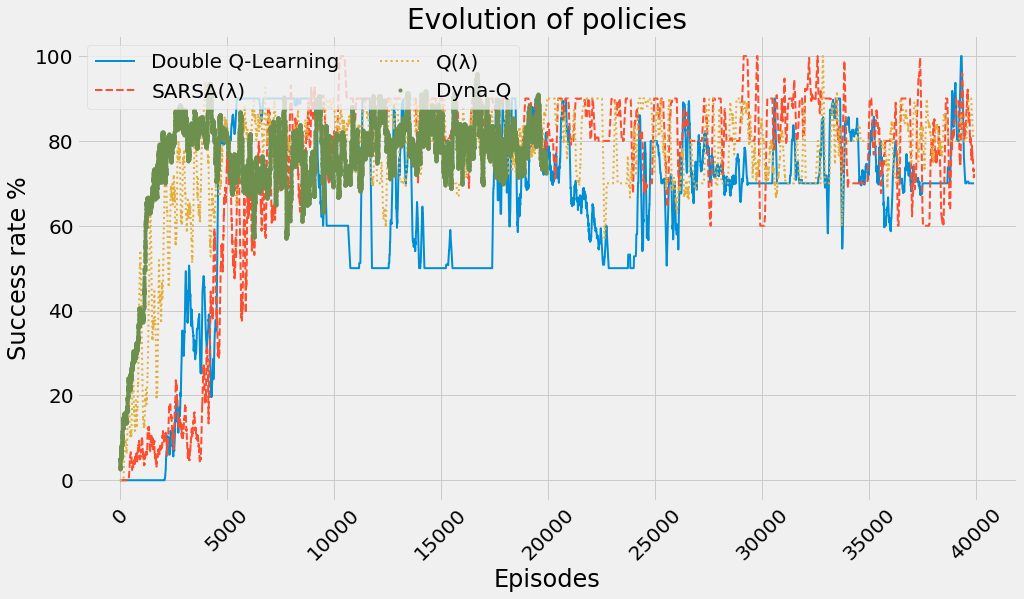

In [75]:
plt.plot(dql_success_evolution, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_success_evolution, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_evolution, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_success_evolution, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

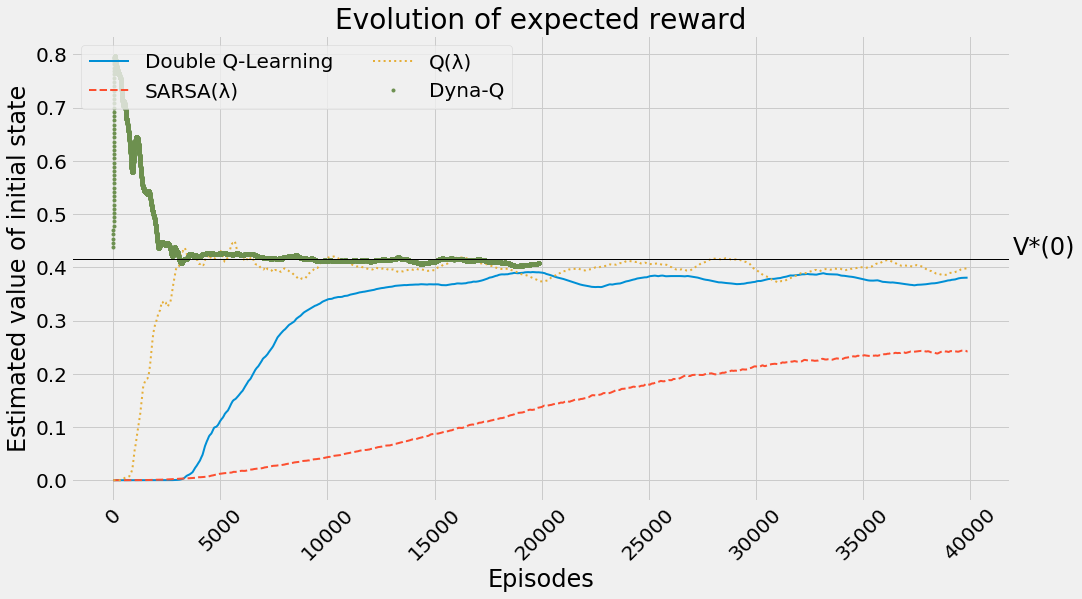

In [76]:
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[0]), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[0]), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[0]), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_dql)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

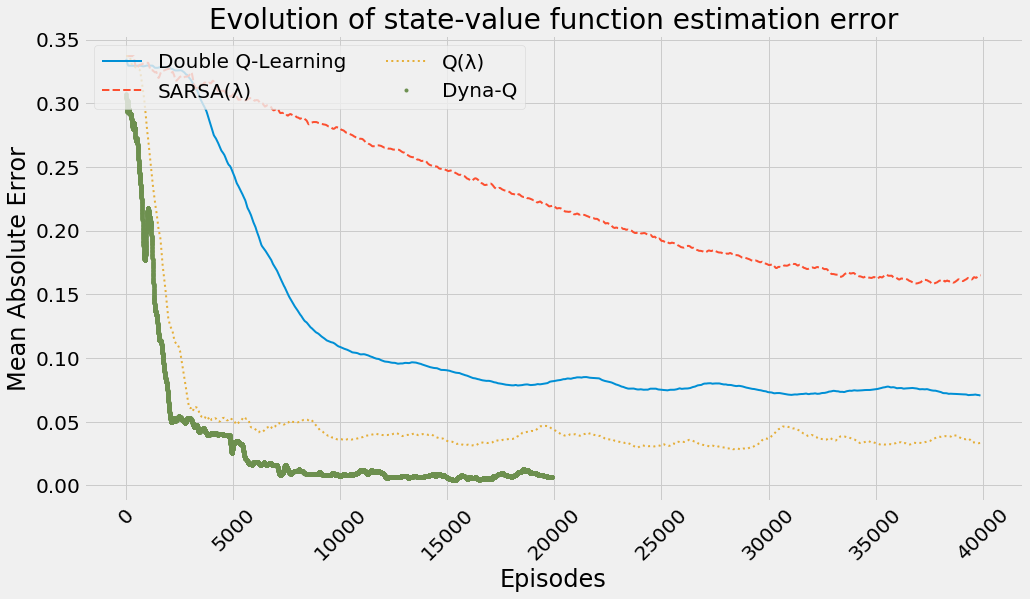

In [77]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

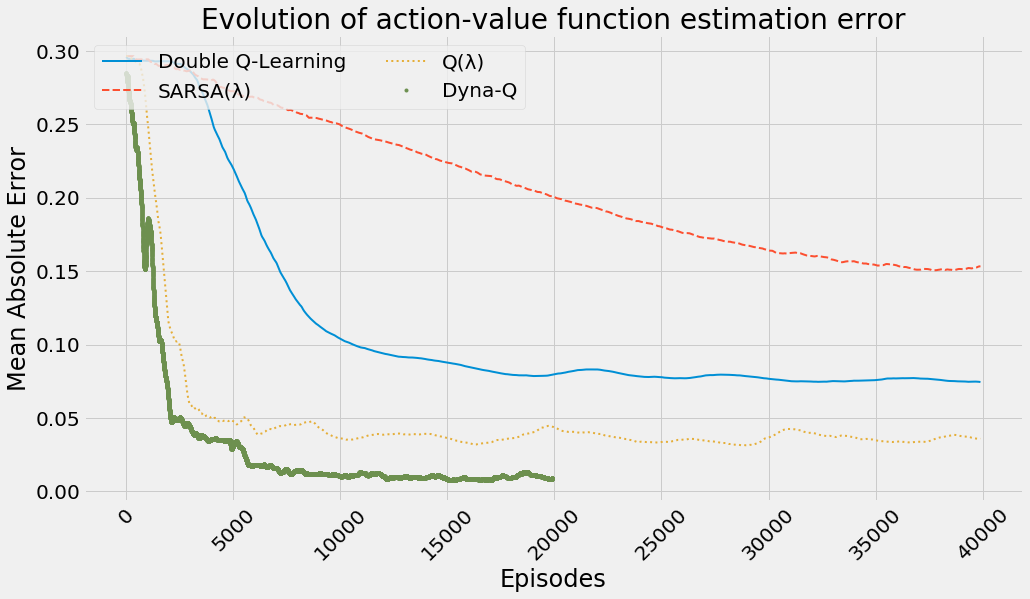

In [78]:
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [79]:
dql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dql)])

In [80]:
sl_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sl)])

In [81]:
qll_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_qll)])

In [82]:
dq_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dq)])

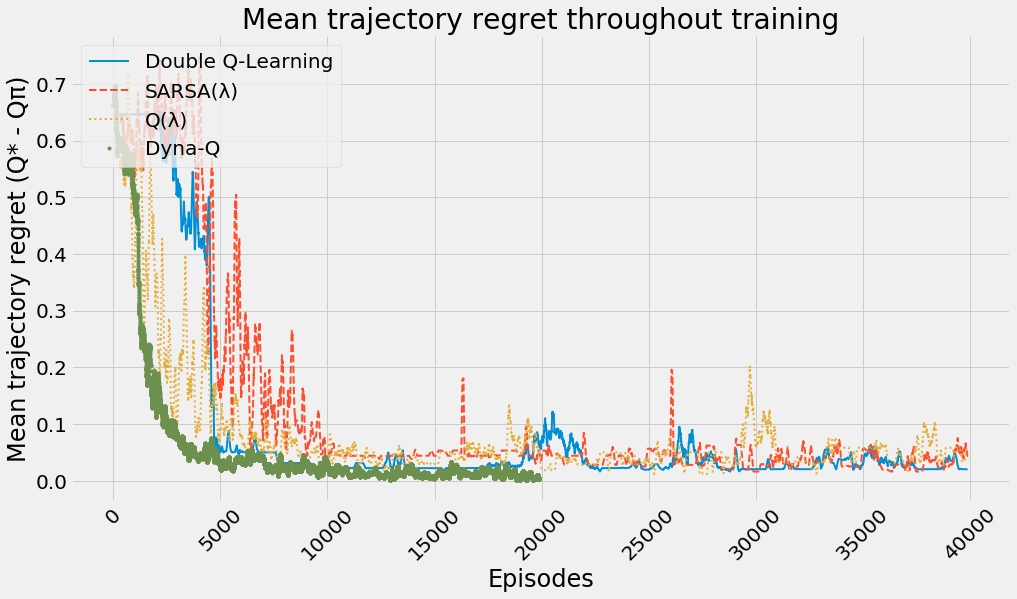

In [83]:
plt.plot(dql_regret_accumulation, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_regret_accumulation, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_regret_accumulation, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_regret_accumulation, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()